In [23]:
import pandas as pd
import networkx as nx
import ast
import matplotlib.pyplot as plt
from collections import defaultdict

In [24]:
interactions_validation = pd.read_csv(r'recipes/interactions_validation.csv')
interactions_test = pd.read_csv(r'recipes/interactions_test.csv')
interactions_train = pd.read_csv(r'recipes/interactions_train.csv')

In [25]:
recipes_df = pd.read_csv(r'recipes/RAW_recipes.csv')

In [26]:
recipes_df['ingredients'] = recipes_df['ingredients'].apply(ast.literal_eval)

In [27]:
recipes_df = recipes_df[recipes_df['ingredients'].apply(len) >= 6]

In [28]:
recipes_df['submitted'] = pd.to_datetime(recipes_df['submitted'], errors='coerce')
recipes_df = recipes_df[recipes_df['submitted'] > '2011-12-31']

In [29]:
recipes_df

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
125,2000 meatloaf,475785,90,2202916,2012-03-06,"['time-to-make', 'course', 'main-ingredient', ...","[267.0, 30.0, 12.0, 12.0, 29.0, 48.0, 2.0]",17,"['pan fry bacon , and set aside on a paper tow...","ready, set, cook! special edition contest entr...","[meatloaf mixture, unsmoked bacon, goat cheese...",13
131,5 tacos,500166,20,2549237,2013-05-13,"['weeknight', '30-minutes-or-less', 'time-to-m...","[249.4, 26.0, 4.0, 6.0, 39.0, 39.0, 0.0]",5,"['cook meat', 'add taco seasoning', 'place mea...",costs about $5.00 to make.,"[ground beef, taco seasoning, taco shells, let...",9
132,50 chili for the crockpot,501028,345,2628680,2013-05-28,"['course', 'main-ingredient', 'cuisine', 'prep...","[270.2, 19.0, 26.0, 48.0, 52.0, 21.0, 4.0]",4,['combine all ingredients in a 7-quart crockpo...,"first, thank you to *parsley* - chef # 199848 ...","[stewing beef, stewing pork, white onion, bell...",22
135,blepandekager danish apple pancakes,503475,50,128473,2013-07-08,"['danish', '60-minutes-or-less', 'time-to-make...","[358.2, 30.0, 62.0, 14.0, 19.0, 54.0, 12.0]",10,"['beat the eggs lightly and add the milk', 'co...",this recipe has been posted here for play in z...,"[eggs, milk, flour, sugar, salt, cream, apples...",10
136,lplermagrone,522861,50,135470,2015-07-25,"['60-minutes-or-less', 'time-to-make', 'course...","[1003.8, 72.0, 21.0, 103.0, 69.0, 143.0, 37.0]",10,['a variant on the theme: in the swiss canton ...,älplermagronethe name doesn't translate perfec...,"[milk, salt, macaroni, cheese, fresh coarse gr...",8
...,...,...,...,...,...,...,...,...,...,...,...,...
231562,zucchinni casserole,505391,55,343262,2013-08-07,"['60-minutes-or-less', 'time-to-make', 'main-i...","[162.3, 15.0, 16.0, 10.0, 17.0, 28.0, 3.0]",7,"['saute peppers , mushrooms & onions in butter...","a good way to use up some of those summer ""zuk...","[green pepper, mushrooms, onion, butter, zucch...",13
231583,zuppa di cipolla al vino rosso,529308,60,2001245595,2016-12-02,"['60-minutes-or-less', 'time-to-make', 'cuisin...","[9282.1, 136.0, 340.0, 715.0, 746.0, 142.0, 58...",22,"['1', 'peel the onions and cut them in thin ri...",onion soup,"[beef broth, butter, onions, flour, oil, black...",10
231604,zurcher geschnetzeltes zurich style veal stri...,471844,45,177443,2012-01-12,"['60-minutes-or-less', 'time-to-make', 'course...","[478.8, 51.0, 8.0, 7.0, 63.0, 82.0, 3.0]",9,"['sprinkle the flour over the veal strips , an...",this is a mouthwatering swiss specialty dish o...,"[veal cutlets, all-purpose flour, butter, oliv...",14
231632,zydeco soup,486161,60,227978,2012-08-29,"['ham', '60-minutes-or-less', 'time-to-make', ...","[415.2, 26.0, 34.0, 26.0, 44.0, 21.0, 15.0]",7,"['heat oil in a 4-quart dutch oven', 'add cele...",this is a delicious soup that i originally fou...,"[celery, onion, green sweet pepper, garlic clo...",22


In [30]:
unique_ingredients = set()
for ingredients_list in recipes_df['ingredients']:
    unique_ingredients.update(ingredients_list)

num_unique_ingredients = len(unique_ingredients)

print(f'Number of unique ingredients: {num_unique_ingredients}')

Number of unique ingredients: 5236


In [31]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: C:\Users\vassa\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [32]:
mapping_df = pd.read_excel('ingredients.xlsx')

In [33]:
ingredient_mapping = dict(zip(mapping_df['raw_ingr'], mapping_df['extracted_ingredient']))

def replace_ingredients(ingredient_list):
    return [ingredient_mapping.get(ingr, ingr) for ingr in ingredient_list]

recipes_df['ingredients'] = recipes_df['ingredients'].apply(replace_ingredients)


In [34]:
all_interactions = pd.concat([interactions_validation, interactions_test, interactions_train])

average_ratings = all_interactions.groupby('recipe_id')['rating'].mean().reset_index()

average_ratings.columns = ['recipe_id', 'average_rating']

In [35]:
ratings_count = all_interactions.groupby('recipe_id')['rating'].count().reset_index()

ratings_count.columns = ['recipe_id', 'num_raters']

average_ratings = average_ratings.merge(ratings_count, on='recipe_id')


recipe_with_ratings = recipes_df.merge(average_ratings, how='left', left_on='id', right_on='recipe_id')

recipe_with_ratings = recipe_with_ratings.drop(columns=['recipe_id'])
recipe_with_ratings['num_raters'] = recipe_with_ratings['num_raters'].fillna(0).astype(int)
recipe_with_ratings['average_rating'] = recipe_with_ratings['average_rating'].fillna(0)

In [36]:
def clean_ingredients(ingredient_list):
    try:
        if isinstance(ingredient_list, str):
            ingredients = ast.literal_eval(ingredient_list)
        else:
            ingredients = ingredient_list

        return [ing.lower().strip() for ing in ingredients if ing.strip()]
    except:
        return []

In [37]:
def create_ingredient_graph(df):
    G = nx.Graph()

    ingredient_cooccurrence = defaultdict(lambda: defaultdict(int))
    ingredient_popularity = defaultdict(list)

    for _, row in df.iterrows():
        ingredients = row['clean_ingredients']
        rating = row['average_rating']
        num_raters = row['num_raters']
        
        for i in range(len(ingredients)):
            for j in range(i+1, len(ingredients)):
                if ingredients[i] != ingredients[j]:
                    if not G.has_edge(ingredients[i], ingredients[j]):
                        G.add_edge(ingredients[i], ingredients[j], weight=1)
                    else:
                        G[ingredients[i]][ingredients[j]]['weight'] += 1
                    
                    pair = tuple(sorted([ingredients[i], ingredients[j]]))
                    ingredient_cooccurrence[pair]['count'] += 1
                    ingredient_cooccurrence[pair]['total_rating'] += rating
                    ingredient_cooccurrence[pair]['total_raters'] += num_raters
    
    for pair, data in ingredient_cooccurrence.items():
        data['avg_rating'] = data['total_rating'] / data['count'] if data['count'] > 0 else 0
        data['avg_raters'] = data['total_raters'] / data['count'] if data['count'] > 0 else 0
    
    return G, ingredient_cooccurrence


In [38]:
def visualize_ingredient_graph(G, top_n=20):
    top_ingredients = sorted(G.degree, key=lambda x: x[1], reverse=True)[:top_n]
    top_graph = G.subgraph([ing for ing, _ in top_ingredients])

    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(top_graph, k=0.5, iterations=50)

    nx.draw(
        top_graph,
        pos,
        with_labels=True,
        node_color='lightblue',
        node_size=[top_graph.degree(node) * 20 for node in top_graph.nodes()],
        font_size=8,
        edge_color='gray',
        alpha=0.7
    )

    edge_labels = nx.get_edge_attributes(top_graph, 'weight')
    nx.draw_networkx_edge_labels(top_graph, pos, edge_labels=edge_labels, font_size=7)

    plt.title("Top Ingredient Connections")
    plt.tight_layout()
    plt.show()


C:\Users\vassa\AppData\Local\Temp\ipykernel_31656\1263557226.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


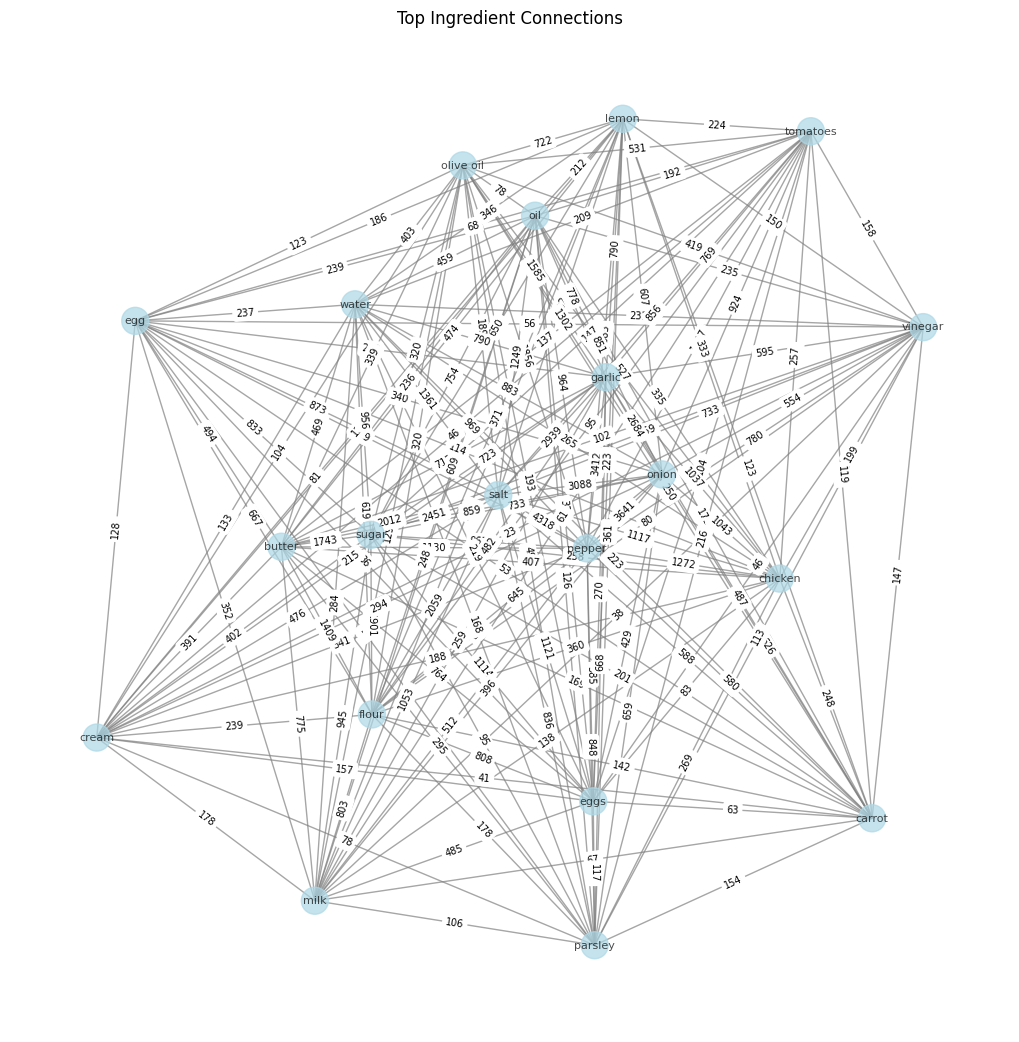

In [39]:
recipe_with_ratings['clean_ingredients'] = recipe_with_ratings['ingredients'].apply(clean_ingredients)
ingredient_graph, ingredient_cooccurrence = create_ingredient_graph(recipe_with_ratings)

nx.write_gml(ingredient_graph,"graphs/ingredients_weighted_graph")

visualize_ingredient_graph(ingredient_graph)

In [40]:
import pickle

ingredient_cooccurrence_dict = {key: dict(value) for key, value in ingredient_cooccurrence.items()}

with open("ingredient_cooccurrence.pkl", "wb") as f:
    pickle.dump(ingredient_cooccurrence_dict, f)

print("Ingredient cooccurrence data saved successfully!")

Ingredient cooccurrence data saved successfully!
